# THƯ VIỆN CẦN THIẾT

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# PHÂN TÍCH DỮ LIỆU
- [INSERT MÔ TẢ SƠ BỘ VỀ 3 FILE/CÁC CÂU HỎI/CÁC BƯỚC LÀM]

## I. TIỀN XỬ LÝ DỮ LIỆU
### Dữ liệu có bao nhiêu dòng, bao nhiêu cột?

In [211]:
df_playlist = pd.read_csv("data/playlist.csv")
df_track    = pd.read_csv("data/track.csv")
df_user     = pd.read_csv("data/user.csv")

df_playlist.shape, df_track.shape, df_user.shape

((3372, 5), (46815, 9), (40129, 5))

### Các file dữ liệu có các dòng nào bị trùng lắp hoàn toàn không?
- Thấy rằng từ output, không có dòng nào bị trùng lắp hoàn toàn trong từng file dữ liệu

In [212]:
df_playlist.duplicated().sum(), df_track.duplicated().sum(), df_user.duplicated().sum()

(0, 0, 0)

### Mỗi cột thuộc kiểu dữ liệu nào? Có cột nào bị thiếu dữ liệu không?
- Với mỗi file, kết hợp 2 công việc này vào 1 dataframe. Dataframe này gồm các cột chính là các cột thuộc tính trong lần lượt 3 file x 2 hàng có tên: 
    - `DataType` - thể hiện kiểu dữ liệu của các thuộc tính trong file
    - `NaN counts` - đếm số lượng dữ liệu thiếu tại mỗi cột  
- Theo đồ án 1, ý nghĩa của mỗi thuộc tính trong mỗi file như sau:
    - `playlist.csv`:
        - `id`: mã của playlist đó, mã này dùng để phân biệt với các playlist khác, mỗi playlist sẽ có một mã số `id` duy nhất.
        - `name`: là tên của playlist đó (trong trường hợp playlist đó không có tên thì ta gán `name` là `null`).
        - `genre`: là thể loại của playlist đó (trong trường hợp playlist đó chưa được đặt thể loại thì ta gán `genre` là `null`).
        - `likes_count`: tổng số lượt likes của playlist
        - `track_ids`: là chuỗi gồm danh sách các track có track_id nằm trong playlist đó.
    - `track.csv`:
        - `id`: id của track. Lưu ý 1 track có thể nằm trong nhiều playlist
        - `name`: tên track
        - `genre`: thể loại track
        - `playlist_id`: playlist_id mà track có mã là `id` thuộc về
        - `author_id`: mỗi track có 1 user có mã đại diện là `author_id` phụ trách
        - `likes_count`: tổng số lượt likes của track
        - `playback_count`: tổng số lượt replay của track
        - `download_count`: tổng số lượt tải về track đó
        - `created_date`: ngày track đó được tạo
    - `user.csv`:
        - `id`: mã người dùng, là duy nhất. Lưu ý 1 người dùng có thể phụ trách 1 hoặc nhiều track
        - `full_name`: họ và tên user
        - `username`: tên tài khoản user
        - `track_id`: track mà user 
        - `followers_count`: số lượng người theo dõi user đó

In [213]:
pd.DataFrame([df_playlist.dtypes, df_playlist.isna().sum()], index= ['DataType', 'NaN counts'])

,playlist_id,playlist_name,genre,likes_count,track_ids
DataType,int64,object,object,int64,object
NaN counts,0,0,2706,0,38


In [214]:
pd.DataFrame([df_track.dtypes, df_track.isna().sum()], index= ['DataType', 'NaN counts'])

,track_id,track_name,track_genre,playlist_id,author_id,likes_count,playback_count,download_count,created_date
DataType,int64,object,object,int64,int64,float64,float64,float64,object
NaN counts,0,0,6623,0,0,882,882,882,0


In [215]:
pd.DataFrame([df_user.dtypes, df_user.isna().sum()], index= ['DataType', 'NaN counts'])

,user_id,full_name,username,track_id,followers_count
DataType,int64,object,object,int64,int64
NaN counts,0,15728,0,0,0


### Xử lý dòng bị thiếu dữ liệu 

### a) Loại dòng thiếu dữ liệu

-  File `playlist.csv`: từ mô tả thuộc tính và kiểu dữ liệu của `track_ids`, thì cần loại đi các playlist không có track nào (tức thuộc tính `track_ids` bị thiếu). Ngoài ra, cũng có 2706 dòng bị thiếu thuộc tính `genre` nhưng qua quan sát sơ bộ file `playlist.csv`, hầu hết tên các playlist (`playlist_name`) sẽ được đặt theo tên thể loại nhạc nên ta sẽ không xóa các dòng thiếu thuộc tính `genre`

In [216]:
df_playlist = df_playlist[df_playlist['track_ids'].notna()]
df_playlist.shape

(3334, 5)

- File `track.csv`: tương tự với cách giải thích của `playlist.csv`, ta sẽ không xóa các dòng thiếu thuộc tính `track_genre`. Tuy nhiên sẽ xóa các dòng thiếu thuộc tính likes_count, playback_count, download_count vì đây là các thuộc tính numeric quan trọng cho bước khám phá dữ liệu sau này

In [217]:
df_track = df_track[(df_track['likes_count'].notna()) & (df_track['playback_count'].notna()) & (df_track['download_count'].notna())]
df_track.shape

(45933, 9)

- File `user.csv`: không xóa dòng nào vì tuy các user có thể không có tên `full_name` nhưng ta vẫn có thể thao tác với dataframe df_user dựa vào định danh của user đó (tức `user_id`) 

### b) Thay thế giá trị trùng thành 1 giá trị khác

- Trong file `playlist.csv`, do cột genre bị thiếu khá nhiều (2706/3372) nên ta không loại các dòng thiếu genre được vì sẽ không đủ dữ liệu. Ngoài ra, có 2 vấn đề phát sinh 
    - _Vấn đề 1_: cột `genre` bị thiếu khá nhiều (2706/3372) nên ta không loại các dòng thiếu `genre` được vì sẽ không đủ dữ liệu để phân tích sau này 
    <br>=> Giải pháp: nội suy từ cột `playlist_name`. Từ quan sát file, thấy rằng hầu hết tên playlist có xu hướng thể hiện luôn thể loại của playlist đó. VD: `playlist_name` = *"Hip Hop Supreme"* thì có thể nội suy được thể loại là **hiphop**
    - _Vấn đề 2_: từ vấn đề 1, thấy rằng ở các playlist thiếu thuộc tính `genre` có thể mang nhiều thể loại. VD: `playlist_name` = *"| Chill | Lofi | Hip Hop |"* thì playlist đó có tới 3 thể loại: **[chill, lofi, hiphop]**. Ngoài ra, kể cả khi playlist có thuộc tính `genre` (VD: `genre` = *"LoFi hip hop"*) thì thấy rằng playlist vẫn có thể mang thuộc về nhiều thể loại
    <br>=> Giải pháp: ta cần phân rã (pd.explode()) cột `genre` phòng trường hợp 1 playlist thuộc nhiều thể loại
    - _Vấn đề 3_: giả sử giải quyết được 2 vấn đề trên thì thấy rằng tên thể loại vẫn chưa đồng nhất (VD: `genre` = *"Blue's_Music"* và `genre` = *"blues"*)
    <br>=> Giải pháp: cần 1 file `keywords.txt` để lưu cứng tên của các thể loại nhạc sẽ xuất hiện trong chuỗi string `genre` (file này được lấy từ project 1 và được tinh chỉnh lại để phù hợp). Ta sẽ chuẩn hóa thể loại dựa vào file này: xét chuỗi thể loại (VD: `genre` = *"Hip-hop & Rap"*), nếu chuỗi thể loại này chứa bất kỳ chuỗi con trong `keywords.txt` (VD: *"hiphop"* và *"rap"*) thì thể loại sẽ được thay bằng (tập) chuỗi con ấy (VD: `genre` sau khi chuẩn hóa = *["hiphop", "rap"]*)
- Kết hợp cả 3 giải pháp trên, ta được cách xử lý sau: 
    - Cộng 2 cột 'playlist_name' & 'genre', nếu 'genre' là NaN thì coi như chuỗi rỗng, kết quả cộng chuỗi lưu vào `df_playlist['genre']`
    - Chuẩn hóa `name_genre` theo giải pháp 3, kết quả sau khi chuẩn hóa là 1 list, lưu lại vào `name_genre`. Sau khi chuẩn hóa có thể vẫn tồn tại NaN nhưng ít hơn (NaN tồn tại là vì cột `playlist_name` không chứa thể loại nhạc nào nên không nội suy được + cột `genre` bị rỗng). Tiến hành bỏ đi các dòng chứa NaN này


In [218]:
with open('data/keywords.txt', encoding= 'utf-8') as f:
    keywords = f.readlines()
keywords = [item.strip('\n').strip(' ') for item in keywords]

In [219]:
# namegenre = playlist_name + playlist_genre
name_genre = df_playlist.apply(lambda row: row['playlist_name'] if pd.isna(row['genre']) else row['playlist_name'] + row['genre'], axis = 1)
name_genre

0          Best Rap Right Now: Drippin'Hip-hop & Rap
1                                    Hip Hop Supreme
2                   Lowfi hip hop chillsLofi Hip Hop
3       Hip-Hop Party Starters: Turn UpHip-hop & Rap
4                    Study & Chill | Lofi HiphopLofi
                            ...                     
3367                 South East Asia Travel Findings
3368                           South East Asia music
3369                                 South East Asia
3370                                 South East Asia
3371                                 Tunes SouthEast
Length: 3334, dtype: object

In [220]:
def list_genres(genre_str):
    res = []

    for keyword in keywords:
        if keyword in genre_str:
            res.append(keyword)

    return res

df_playlist['genre'] = name_genre.apply(lambda val: list_genres(re.sub(r'(hip-hop|hip hop)', 'hiphop', val.lower())))
print("Số lượng NaN từng cột:")
print(df_playlist.explode('genre').isna().sum())
df_playlist = df_playlist.explode('genre').dropna()

df_playlist

playlist_id        0
playlist_name      0
genre            513
likes_count        0
track_ids          0
dtype: int64


,playlist_id,playlist_name,genre,likes_count,track_ids
0,730118454,Best Rap Right Now: Drippin',hiphop,385829,"1134572425,1137390457,1144461559,1150000726,11..."
0,730118454,Best Rap Right Now: Drippin',rap,385829,"1134572425,1137390457,1144461559,1150000726,11..."
1,380154338,Hip Hop Supreme,hiphop,178944,"594112890,596212962,593601912,597082389,597563..."
2,306226961,Lowfi hip hop chills,hiphop,204029,"216774635,406234053,755194606,266707458,670884..."
2,306226961,Lowfi hip hop chills,chill,204029,"216774635,406234053,755194606,266707458,670884..."
...,...,...,...,...,...
3366,503370612,SOUTH EAST ASIA,asia,1,"298786858,813312181"
3367,17969127,South East Asia Travel Findings,asia,0,10764237
3368,774255861,South East Asia music,asia,0,485316636
3369,345496216,South East Asia,asia,0,315565008


### Chuyển đổi kiểu dữ liệu cho phù hợp


- File `playlist.csv`: từ mô tả thuộc tính và kiểu dữ liệu của `track_ids`, thì cần đổi kiểu dữ liệu của thuộc tính `track_ids` từ **string** sang dạng **list các số nguyên**

In [221]:
df_playlist['track_ids'] = df_playlist['track_ids'].apply(lambda x: [int(item) for item in x.split(',')])

- File `track.csv`: 
    - Cần đổi kiểu dữ liệu của 2 cột `likes_count`, `playback_count`từ **float** sang **int**
    - Cần đổi kiểu dữ liệu của `created_date` sang kiểu **datetime**

In [222]:
df_track[['likes_count', 'playback_count', 'download_count']] = df_track[['likes_count', 'playback_count', 'download_count']].astype(int)
df_track['created_date'] = pd.to_datetime(df_track['created_date'])
# df_track[['likes_count', 'playback_count', 'download_count', 'created_date']].head()

### Kiểm tra ngoại lệ

In [223]:
# SOMETHING HERE

# II. KHÁM PHÁ DỮ LIỆU

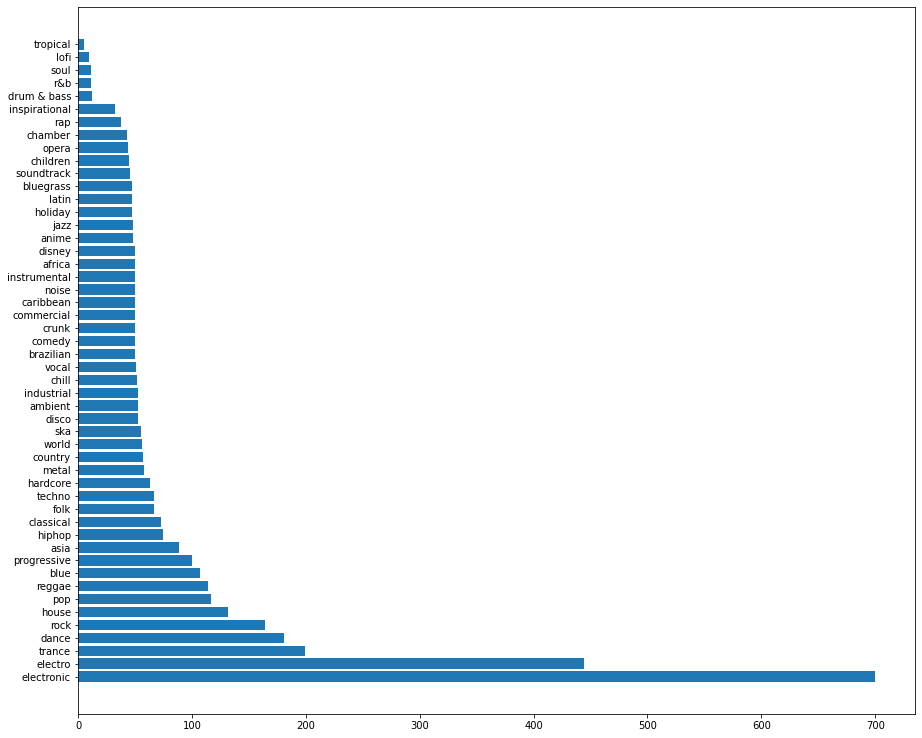

In [224]:
genre_stat = df_playlist['genre'].value_counts()
plt.figure(figsize=(15, 13))
a = plt.barh(genre_stat.index, genre_stat)